# Selling Second Hand Cars # 

## Introduction ## 

This notebook gives an overview of the process used to data extraction and cleaning, as well as the modelling process that underpins the models used in askahseng.com, a web app for generating price predictions and selling probabilities for second hand cars in Singapore. 

## Outline ## 

1. [Data Collection](#collect)
2. [Data Exploration](#explore)
3. [Predicting OMV (Open Market Value)](#omv)
4. [Predicting Value](#value)
5. [Predicting Probability of selling within 7 days](#proba)



In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.sql import text
from dateutil.relativedelta import relativedelta
import re
from private import * 
from train_models import * 

sns.set_style("whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [15]:
engine = create_engine('postgresql://',creator=connect)

In [16]:
cars = get_cars_df()
coe_long =get_coe_df()
cars= clean_cars(cars,coe_long)
cars= impute_mileage(cars)

In [198]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

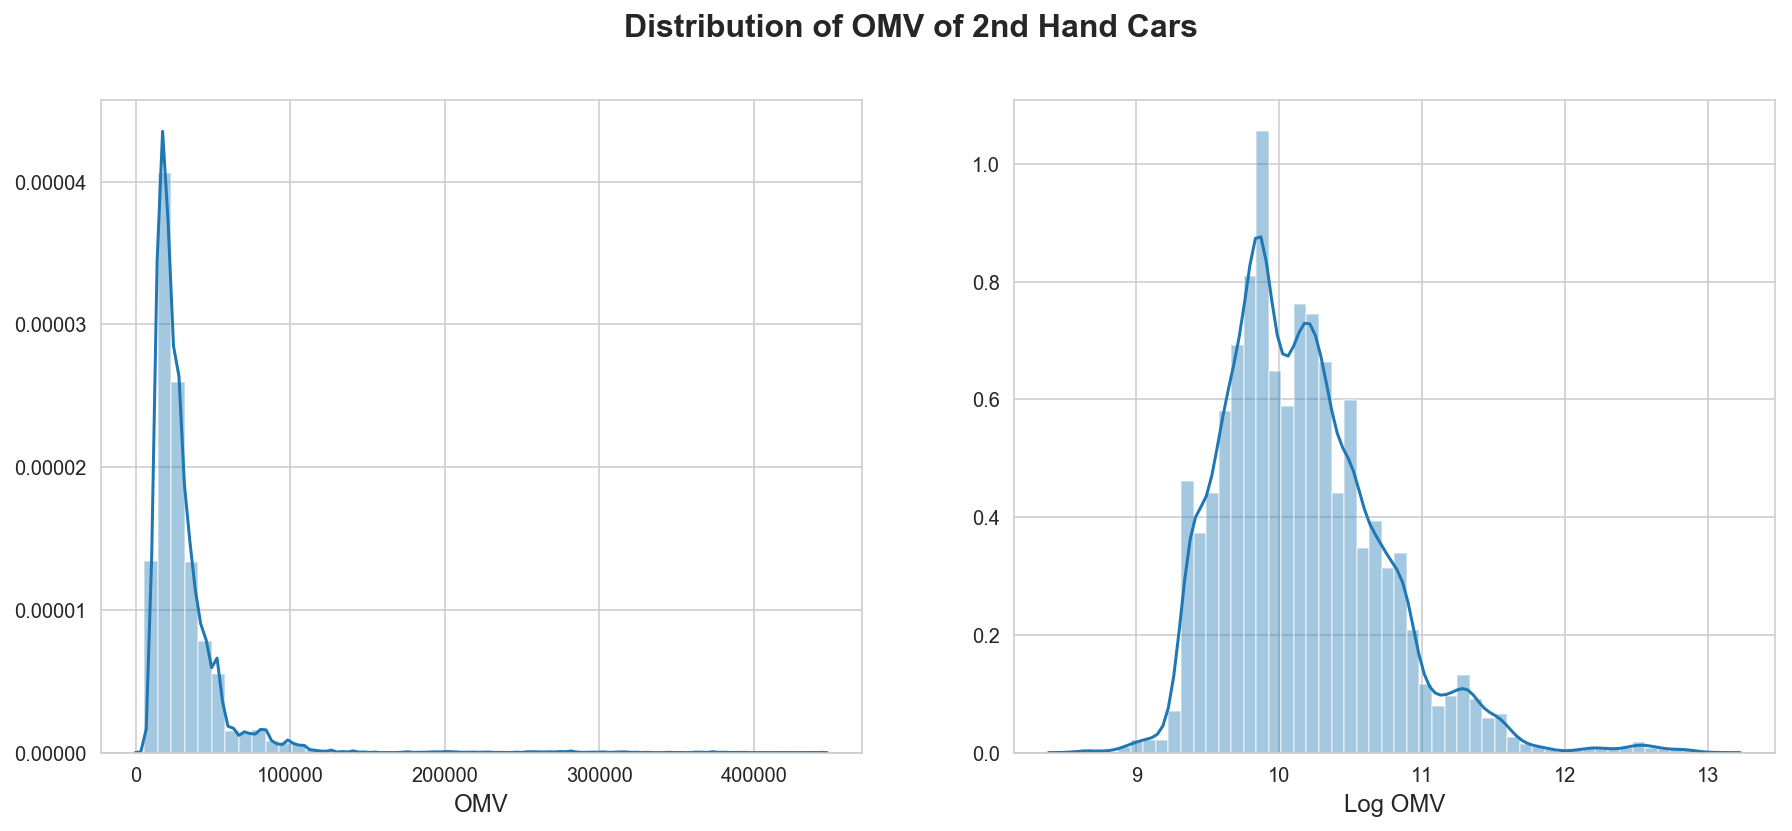

In [4]:
f,ax=plt.subplots(1,2,figsize=(15,6))
sns.distplot(cars['omv'],ax=ax[0])
ax[0].set_xlabel('OMV',fontsize=12)
sns.distplot(np.log(cars['omv']),ax=ax[1])

ax[1].set_xlabel('Log OMV',fontsize=12)
f.suptitle('Distribution of OMV of 2nd Hand Cars',fontsize=16,fontweight='bold')
plt.show()

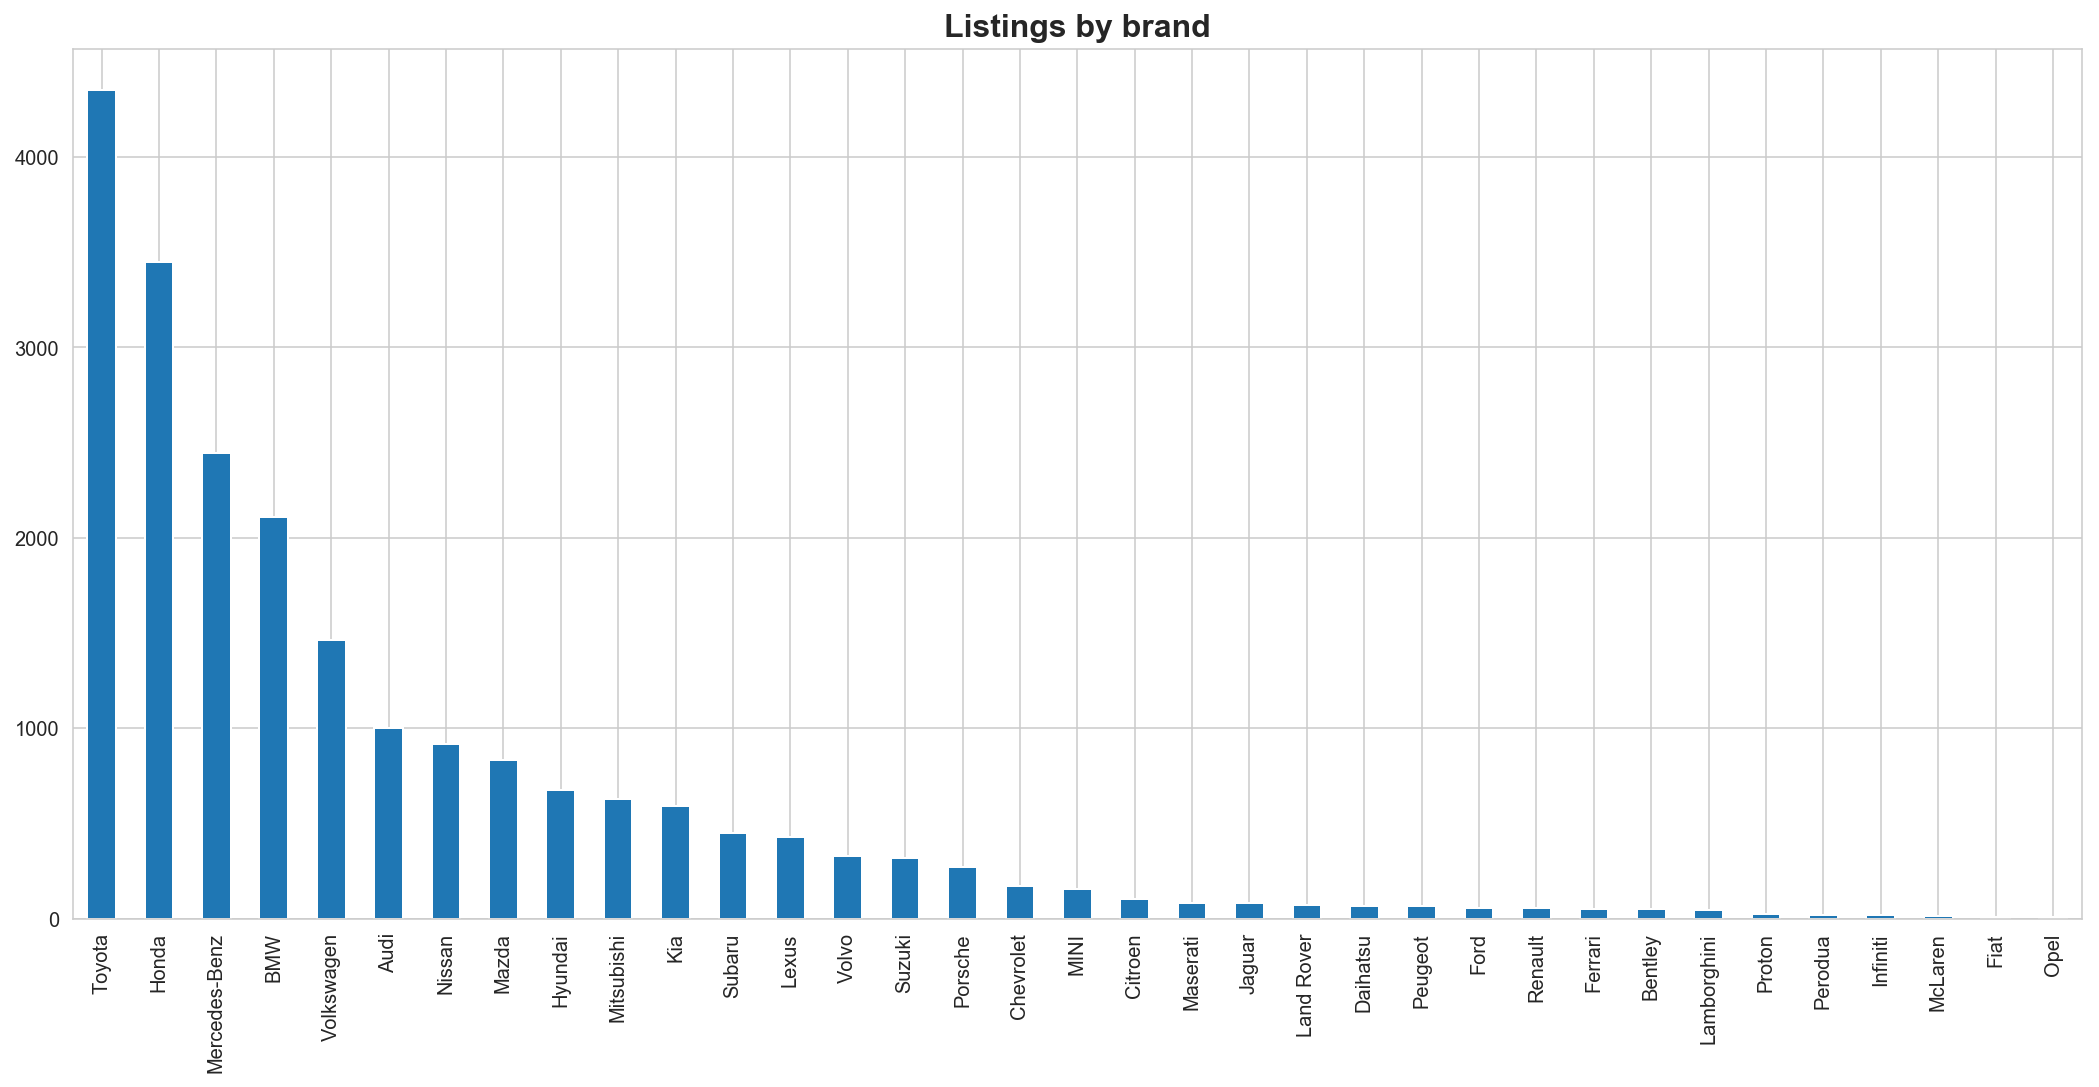

In [6]:
plt.figure(figsize=(18,8))
cars['brand'].value_counts().plot.bar()
plt.title('Listings by brand',fontsize=16,fontweight='bold')
plt.show()

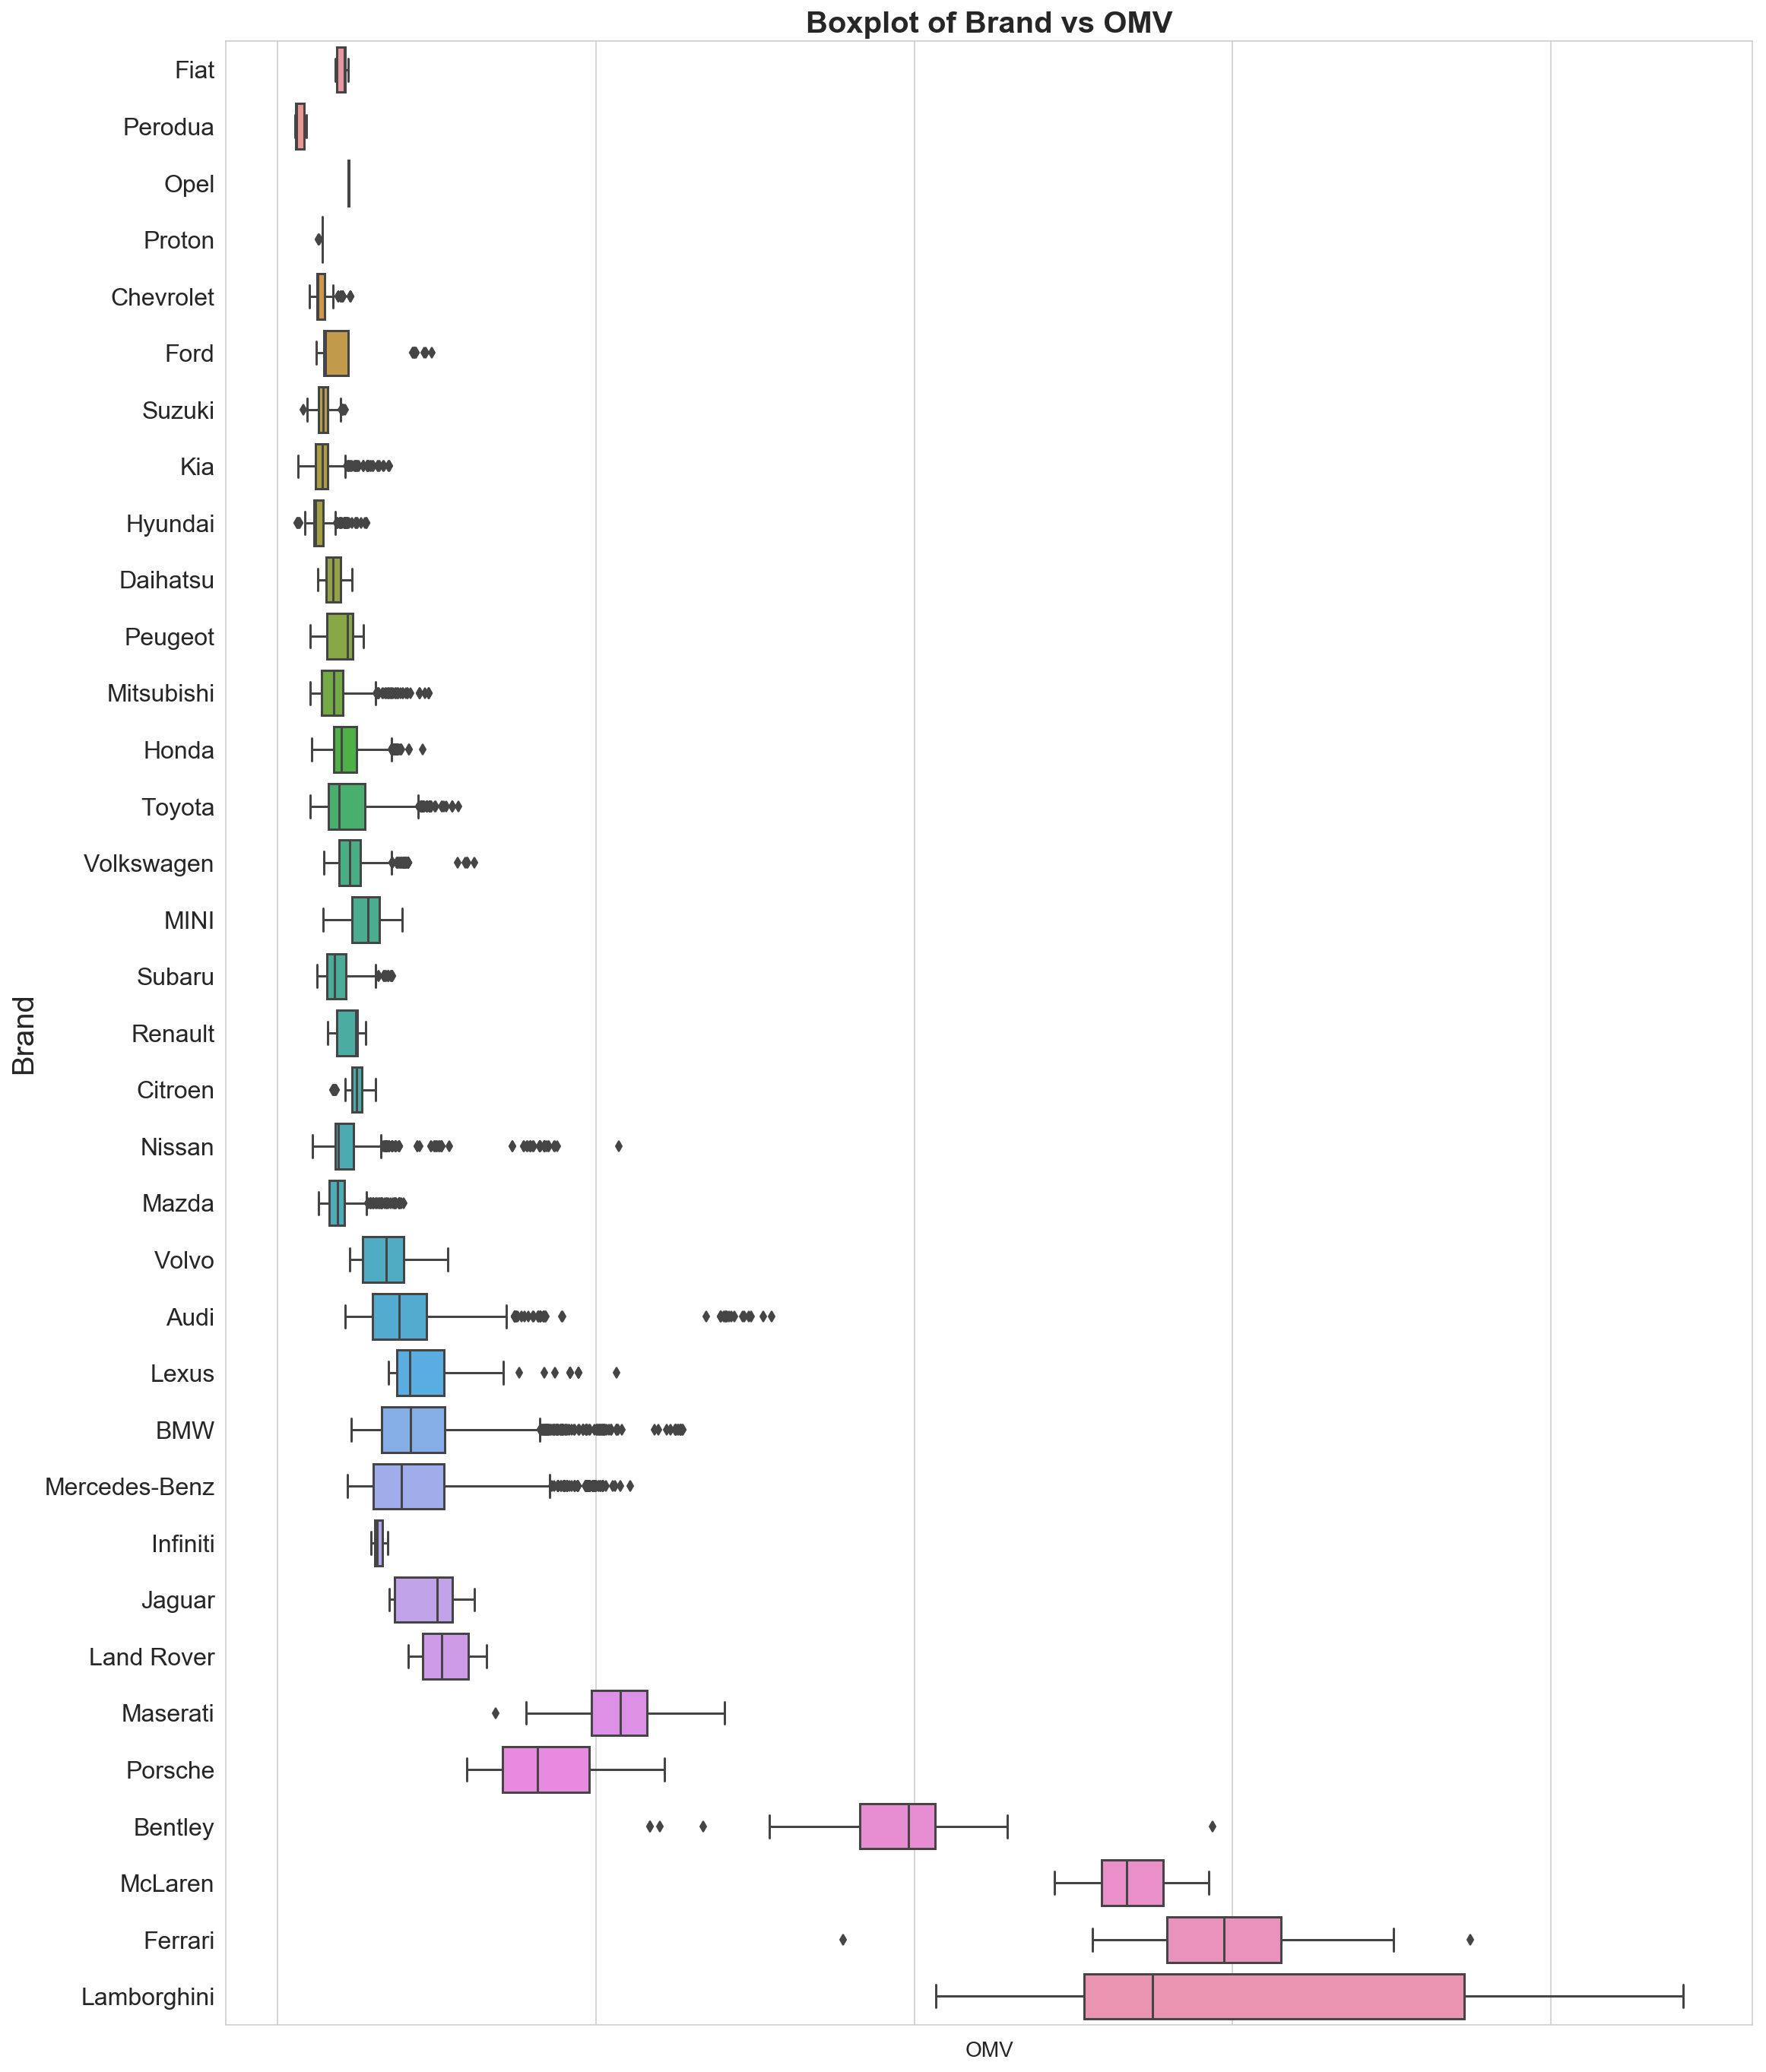

In [258]:
plt.figure(figsize=(18,24))
ax=sns.boxplot(y='brand',x='omv',data=cars,orient='h',order=cars['price'].groupby(cars['brand']).median().sort_values(ascending=True).index)
ax.set_ylabel('Brand',fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=16)
ax.set_xlabel('OMV',fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=16)
plt.title('Boxplot of Brand vs OMV',fontsize=20,fontweight='bold')
plt.show()

In [8]:
num_feats=[i for i in list(cars.select_dtypes('number').columns) if i.split('_')[0] != 'is']

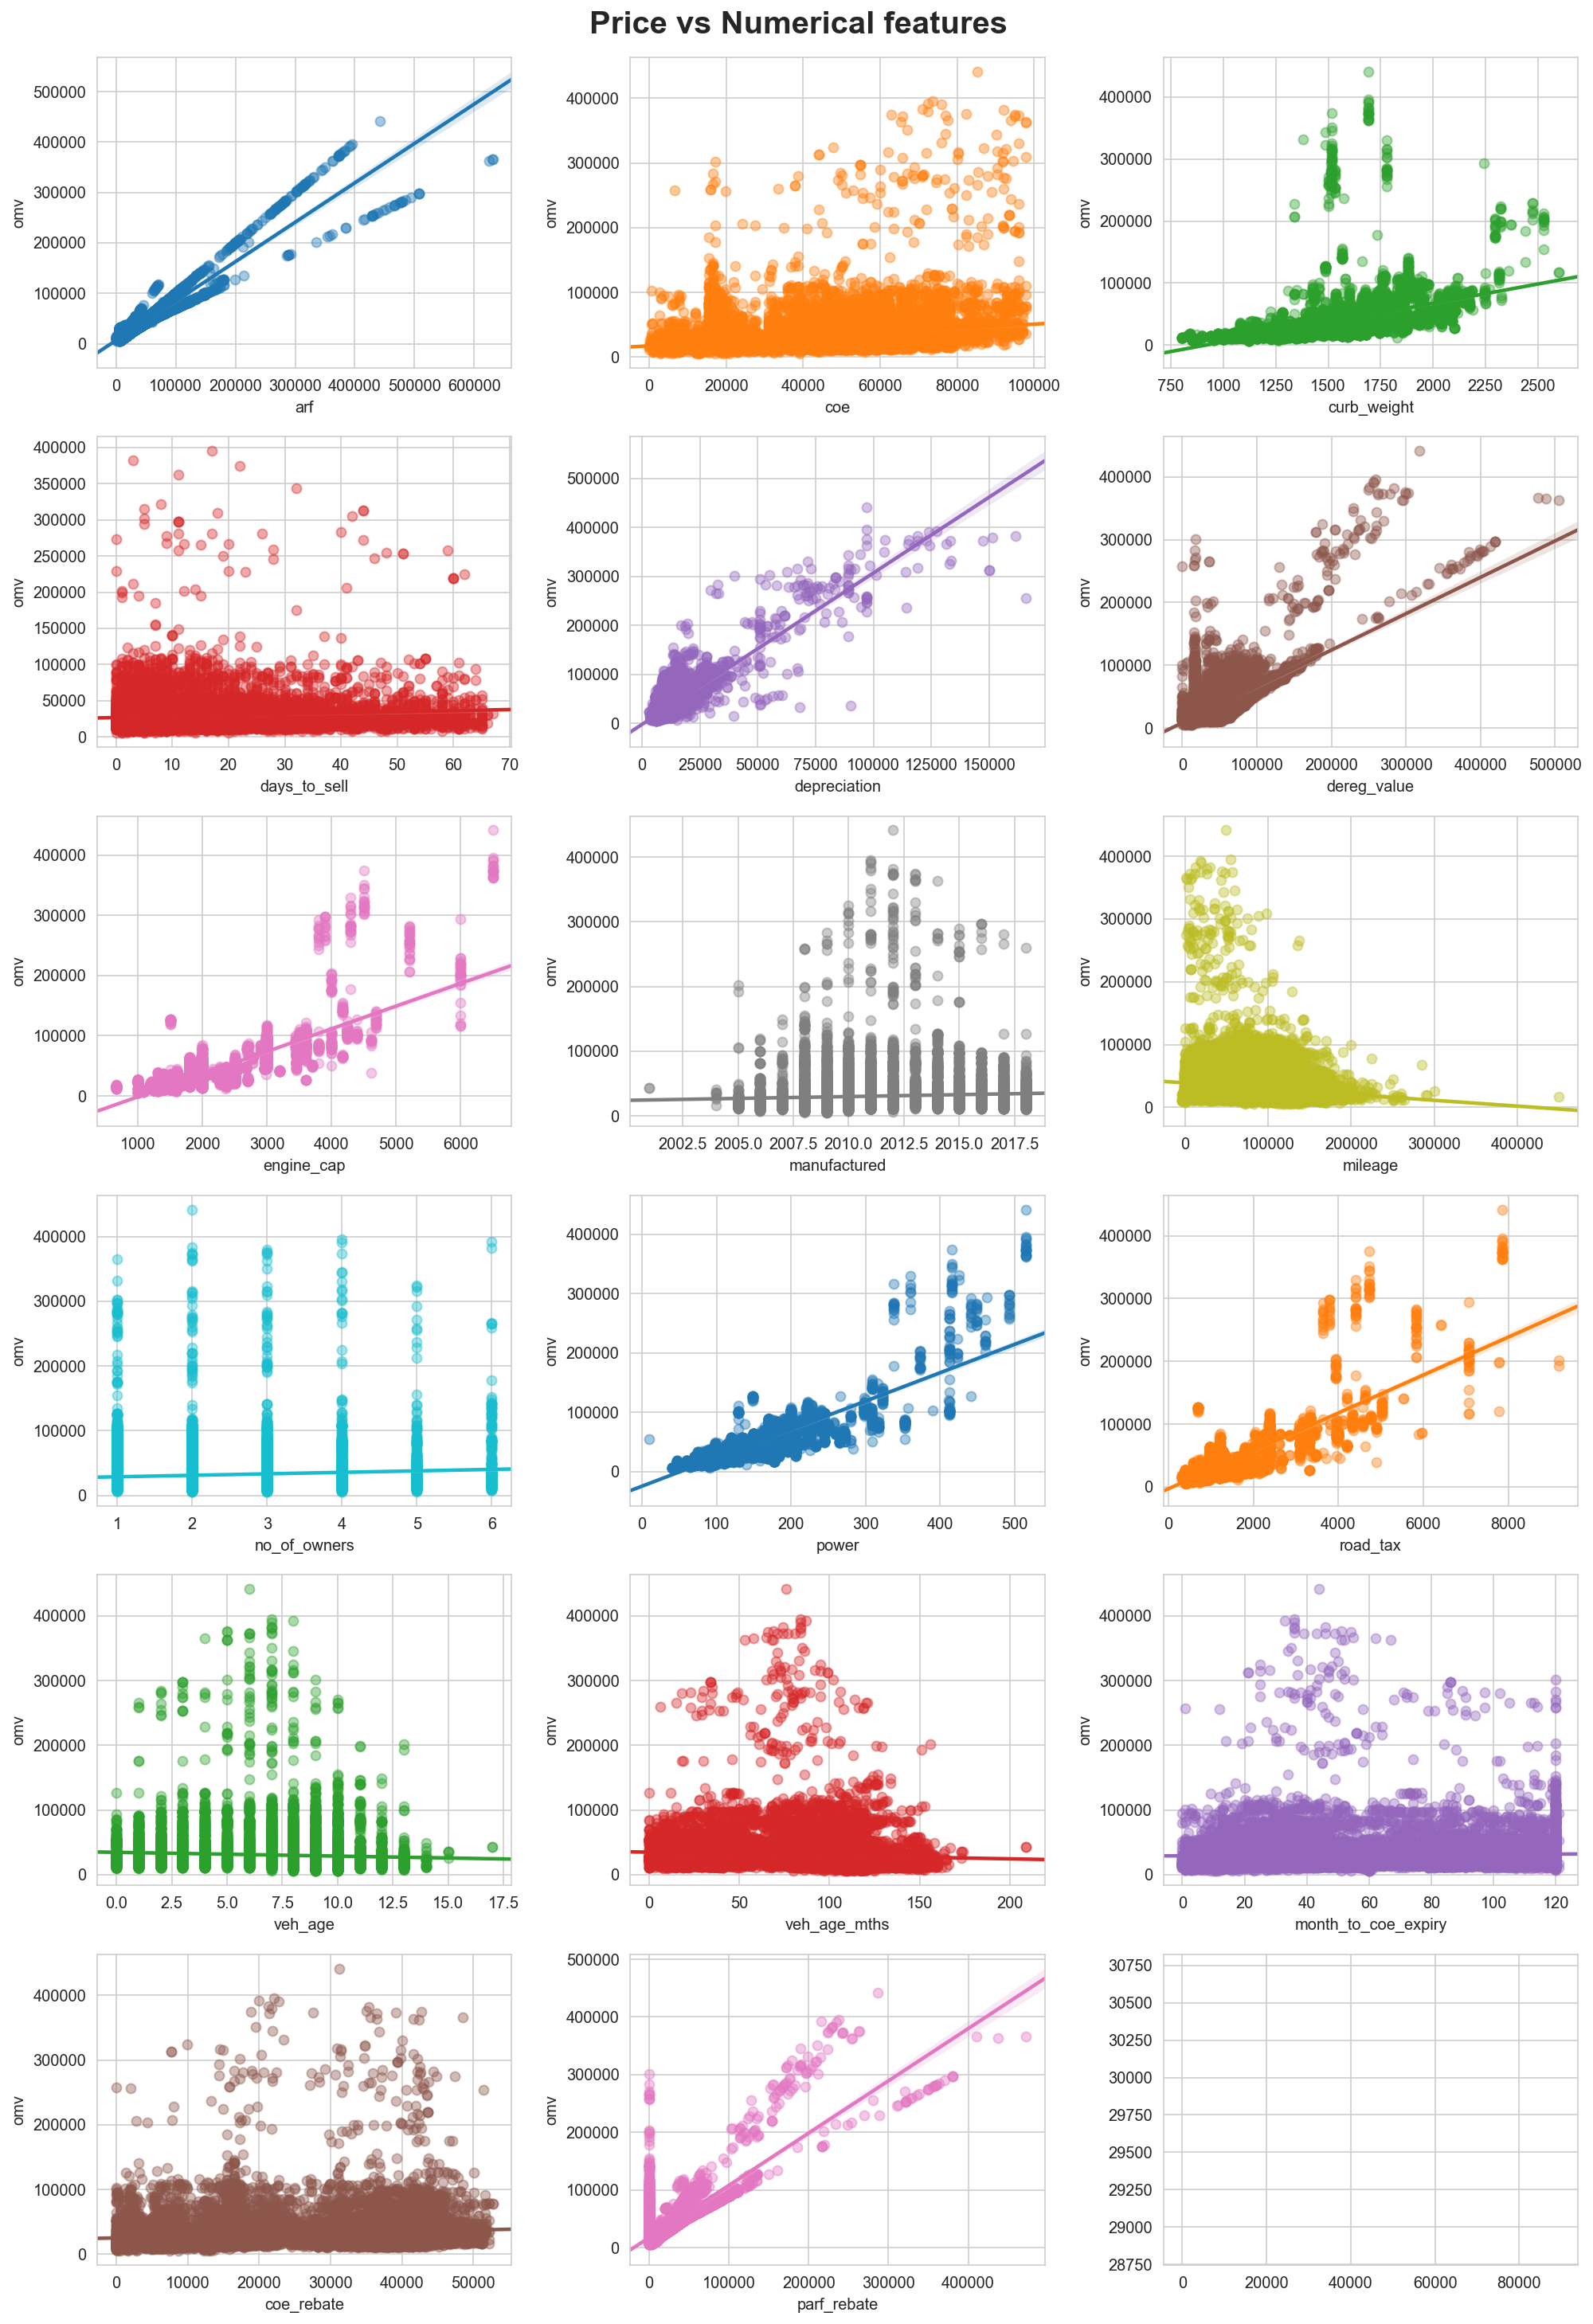

In [9]:
num_feats.remove('price')
num_feats.remove('omv')
num_feats.remove('value')
f, ax= plt.subplots(6,3,figsize=(14,20))
ax[5,2].axis('off')
axes=ax.flatten()

for x,ax in zip(num_feats,axes):
    sns.regplot(x=x,y='omv',data=cars,ax=ax,scatter_kws={"alpha": 0.4})
f.suptitle('OMV vs Numerical features',fontsize=20,y=1.01,fontweight='bold')
plt.tight_layout()

In [231]:
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [222]:
brand_dums=pd.get_dummies(cars['brand'],prefix='brand_is')
brand_dums.drop(columns='brand_is_Toyota',inplace=True)
fuel_dums=pd.get_dummies(cars['fuel_type'],prefix='fuel_is')
fuel_dums.drop(columns='fuel_is_Diesel',inplace=True)
model_dums=pd.get_dummies(cars['model'],drop_first=True)

In [232]:
y=np.log(cars['omv'])
X_num=cars[['engine_cap','power','curb_weight','veh_age_mths']]
X=pd.concat([X_num,model_dums,brand_dums],axis=1)
Xtrain,Xtest,ytrain,ytest= train_test_split(X,y,random_state=123)

In [234]:
def cross_val_reg(model,name,X,y,scoring=None,folds=5):
    
    '''
        Takes a model, ie. instantiated class object, feature and target set and performs 
        5 fold cross validation using R^2 as a metric.
        
        Prints the scores, mean and std of the scores. 
        
    '''
    print( '------------------------------------\n')
    print('{}-Fold Cross Validated Results for Model: '.format(folds)+ name)
    
    # Compute cross val score # 
    
    scores = cross_val_score(model, X, y, cv=folds,scoring=scoring)
    
    if scoring==None:

        print('Performance Metric: R2')


    else:
        print('Performance Metric: ' + scoring )
        
    print("Cross-validated scores:", scores)
    print("Mean score:", np.mean(scores))
    print('Std score:', np.std(scores))
    

    
    return np.mean(scores)



In [235]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

In [237]:
# Fit RF obtained from tuning hyperparameters # 

rf=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [238]:
rf.fit(Xtrain,ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [239]:
cross_val_reg(rf,'Random Forest',Xtrain,ytrain,scoring='neg_mean_squared_error')

------------------------------------

5-Fold Cross Validated Results for Model: Random Forest
Performance Metric: neg_mean_squared_error
Cross-validated scores: [-0.00308927 -0.00385301 -0.00295034 -0.00310228 -0.00316337]
Mean score: -0.003231654967256134
Std score: 0.00031840048561559866


-0.003231654967256134

In [273]:
np.exp(0.003231654967256134)

1.0032368823937325

In [263]:
print('RMSE for RF is {}'.format(np.sqrt(sum((np.exp(y)-np.exp(rf.predict(X)))**2)/X.shape[0]-1)))

RMSE for RF is 1254.8026343524787


In [264]:
ridge_alphas = np.logspace(-2, 7, 50)
ridgecv = RidgeCV(alphas=ridge_alphas, cv=10)

ridgecv.fit(Xtrain,ytrain)

ridge=Ridge(alpha=ridgecv.alpha_)
ridge.fit(Xtrain,ytrain)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [265]:
cross_val_reg(ridge,'Ridge',Xtrain,ytrain,scoring='neg_mean_squared_error')

------------------------------------

5-Fold Cross Validated Results for Model: Ridge
Performance Metric: neg_mean_squared_error
Cross-validated scores: [-0.00660549 -0.00709842 -0.00627418 -0.00620739 -0.00634284]
Mean score: -0.006505663669779174
Std score: 0.0003256980425846747


-0.006505663669779174

In [272]:
np.exp(0.006505663669779174)

1.0065268714649884

In [267]:
print('RMSE for Ridge is {}'.format(np.sqrt(sum((np.exp(y)-np.exp(ridge.predict(X)))**2)/X.shape[0]-1)))

RMSE for Ridge is 3135.100935687293


In [268]:
lassocv = LassoCV(n_alphas=500, cv=10)
lassocv.fit(Xtrain,ytrain)

lasso= Lasso(alpha=lassocv.alpha_)
lasso.fit(Xtrain,ytrain)

Lasso(alpha=0.23535945582416104, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [269]:
cross_val_reg(lasso,'Lasso',Xtrain,ytrain,scoring='neg_mean_squared_error')

------------------------------------

5-Fold Cross Validated Results for Model: Lasso
Performance Metric: neg_mean_squared_error
Cross-validated scores: [-0.06588372 -0.06723002 -0.06468863 -0.06610253 -0.06368506]
Mean score: -0.06551799125740096
Std score: 0.0012209820368045256


-0.06551799125740096

In [274]:
np.exp(0.12388862027066812)

1.131889794399183

In [270]:
print('RMSE for Lasso is {}'.format(np.sqrt(sum((np.exp(y)-np.exp(lasso.predict(X)))**2)/X.shape[0]-1)))

RMSE for Ridge is 15125.34594838785


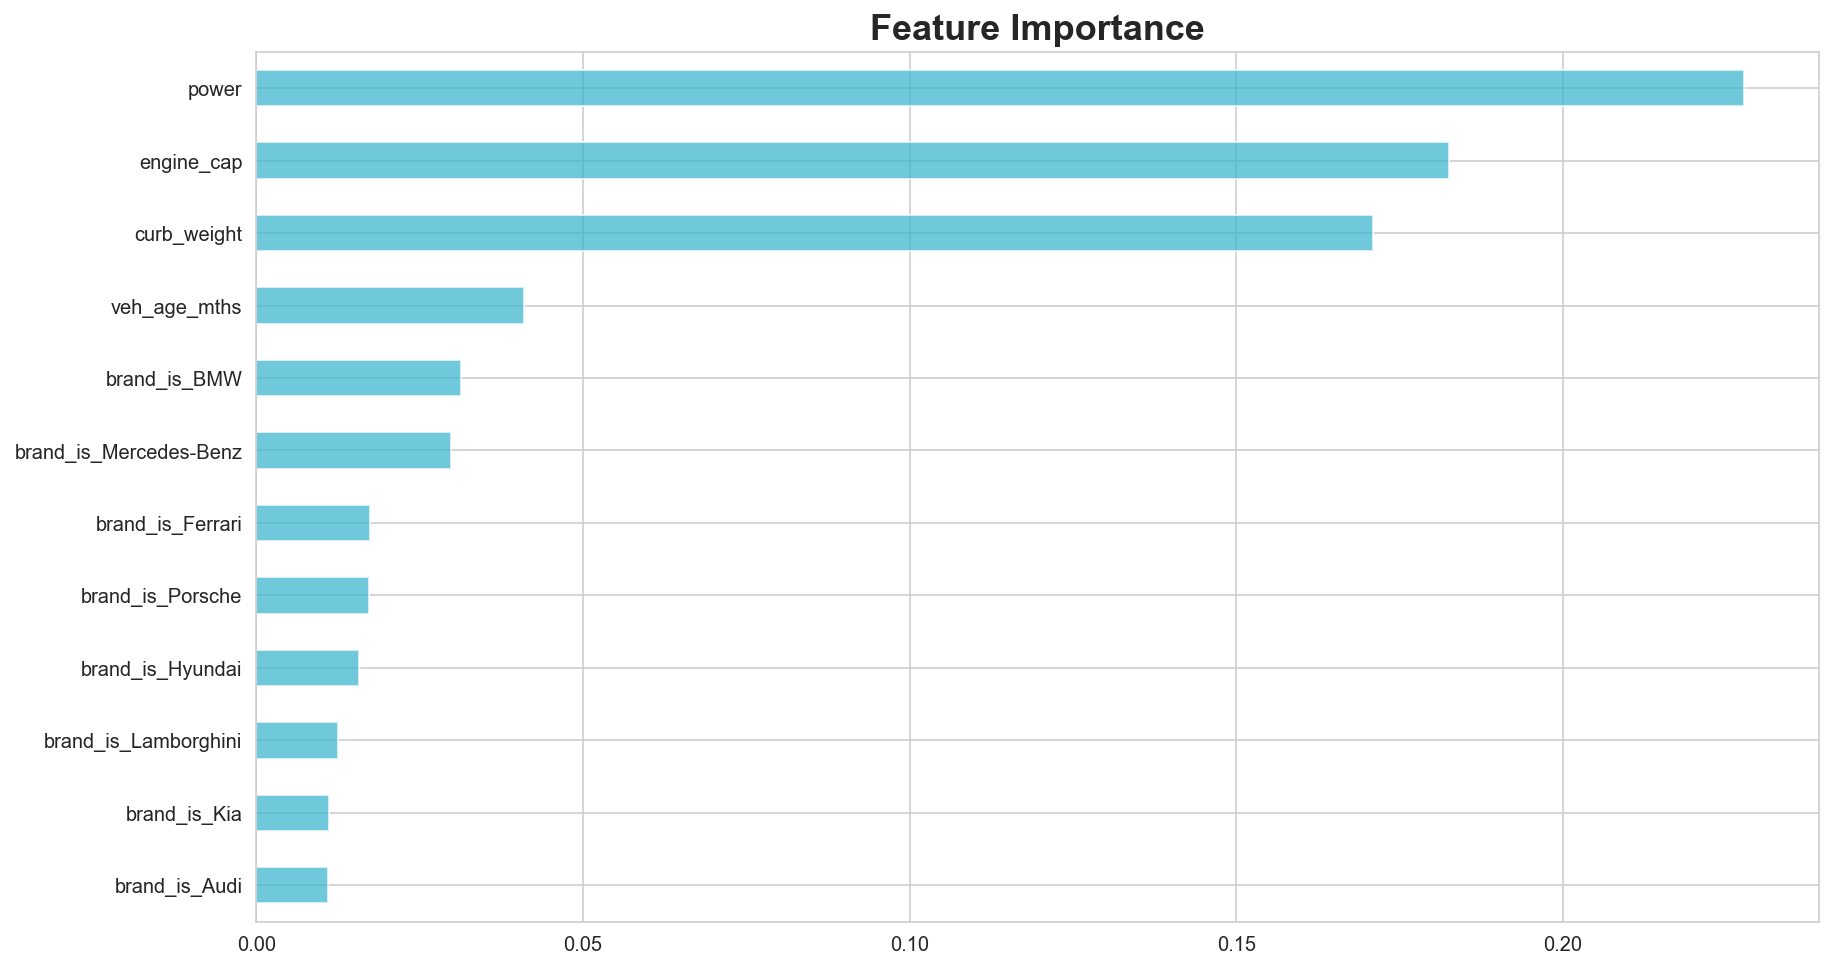

In [242]:
rfr_feats=pd.DataFrame({'variable':X.columns,
 'feature_importance':rf.feature_importances_})

rfr_feats.sort_values(by='feature_importance',inplace=True)
f=plt.figure(figsize=(14,8))

# Look at features which have importance above >0.01 # 
ax=rfr_feats['feature_importance'][rfr_feats['feature_importance']>0.01].plot.barh(color=(0.2,0.7,0.8),alpha=0.7)
ax.set_yticklabels(rfr_feats['variable'][rfr_feats['feature_importance']>0.01])
ax.set_title('Feature Importance',fontsize=18,fontweight='bold')
plt.show()

In [84]:
from sklearn.externals import joblib


['./flask/OMV.pkl']

In [251]:

def residual_plot(model,name,X,y,color):
    
    # Generate reisduals #
    preds=model.predict(X)
    resids=y-preds

    
    # Plot reisduals vs y first # 
    
    ax=sns.scatterplot(preds,resids,alpha=0.2,color=color)
    
    # Add y=0 line # 
    uplim=max(ax.get_xlim())
    lowlim=min(ax.get_xlim())
    lines=np.linspace(lowlim,uplim)
    zeros=np.zeros(50)
    plt.plot(lines,zeros,linestyle='--')
    
    # Set title # 
    ax.set_title(name,fontsize=12)
    
    # Set labels # 
    ax.set_ylabel('Residuals')
    ax.set_xlabel('Predicted')

    

def act_pred_plots(model,name,X,y,color):
    '''
        Takes a model, its name, feature set and predictor set and returns an actual vs predicted plot
    '''

    # Generate predictions #
    preds=model.predict(X)
    
    # Plot reisduals vs y first # 

    ax=sns.scatterplot(preds,y,alpha=0.2,color=color)

    
    # Make it a square plot # 
    uplim=max(ax.get_xlim()+ax.get_ylim())
    lowlim=min(ax.get_xlim()+ax.get_ylim())
    ax.set_xlim(lowlim,uplim)
    ax.set_ylim(lowlim,uplim)
    
    # Add unit line # 
    lines=np.linspace(lowlim,uplim)
    plt.plot(lines,lines,linestyle='--')
    # Set title # 
    ax.set_title(name,fontsize=12)
    
    # Set axis labels # 

    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

In [178]:
# Generate new covariance matrix and residual error # 

preds=xgbr.predict(X_2)
resids=Y-preds
var=np.sum([resid**2 for resid in resids])/(X_2.shape[0]-X_2.shape[1])
cov=np.linalg.inv(np.dot(X_2.T,X_2))

np.save('./flask/cov.npy',np.linalg.inv(np.dot(X_2.T,X_2)))
np.save('./flask/residual_error.npy',np.sum([resid**2 for resid in resids])/(X_2.shape[0]-X_2.shape[1]))

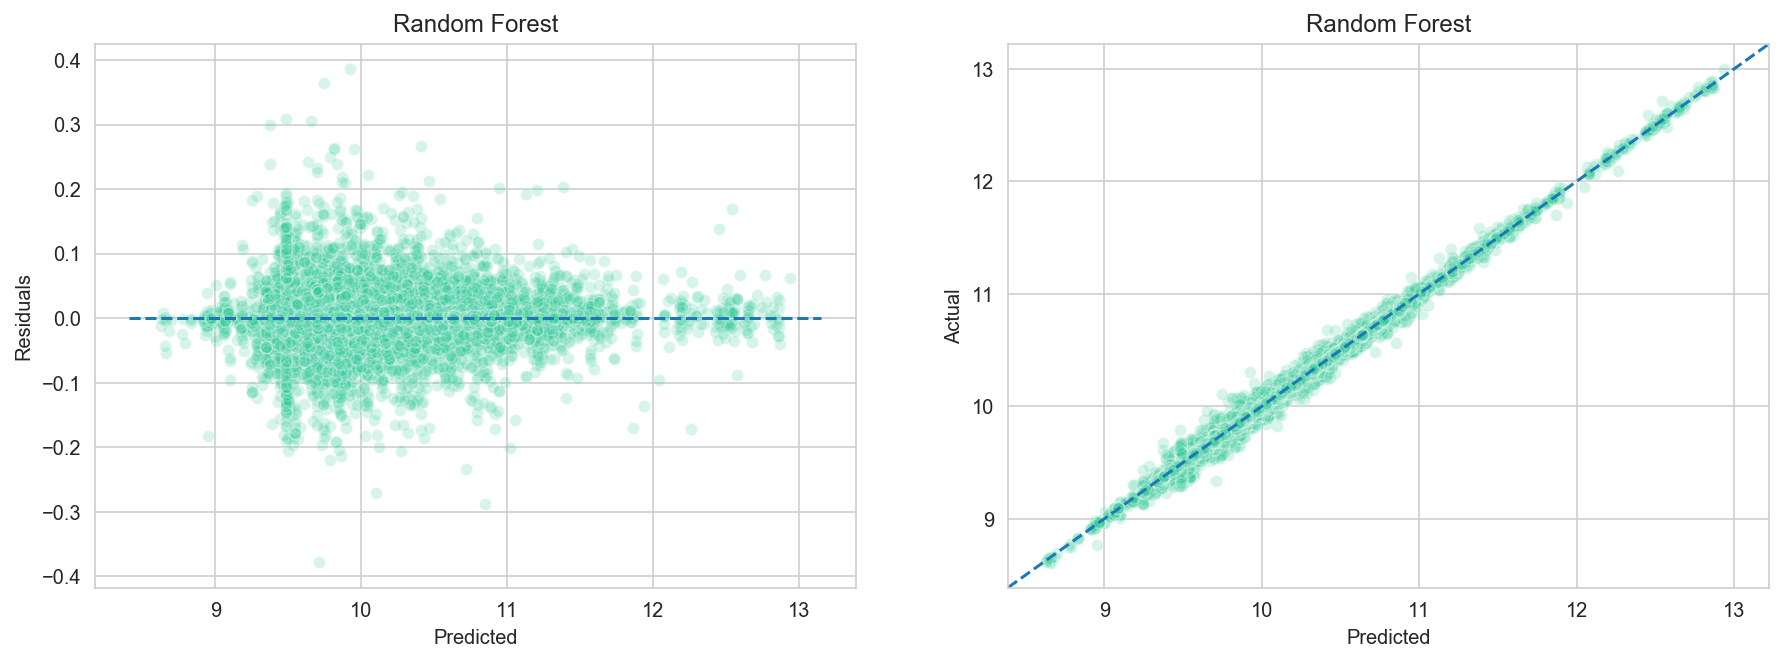

In [252]:
plt.figure(figsize=(15,5))
plt.subplot(121)
residual_plot(rf,"Random Forest",X,y,color=(0.2,0.8,0.6))
plt.subplot(122)
act_pred_plots(rf,"Random Forest",X,y,color=(0.2,0.8,0.6))

plt.show()


